In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import heapq
from queue import PriorityQueue
%matplotlib inline

columns = ['StartingStation', 'EndingStation', 'TubeLine', 'AverageTimeTaken', 'MainZone', 'SecondaryZone']
df = pd.read_csv ('tubedata.csv', header=None)      # Reading the csv in Pandas Python Library
df1 = pd.read_csv('tubedata.csv', names= columns)   # Creating another data frame with headers

The above lines of code imports the necessary packages required for implementation of all the Uninformed Search. In the following part, the data is prepared in the form of a nxgraph and a dict which will have the information required to implement the Extended and Heuristic searches.

Note: Add two CSVs, both with and without headers.

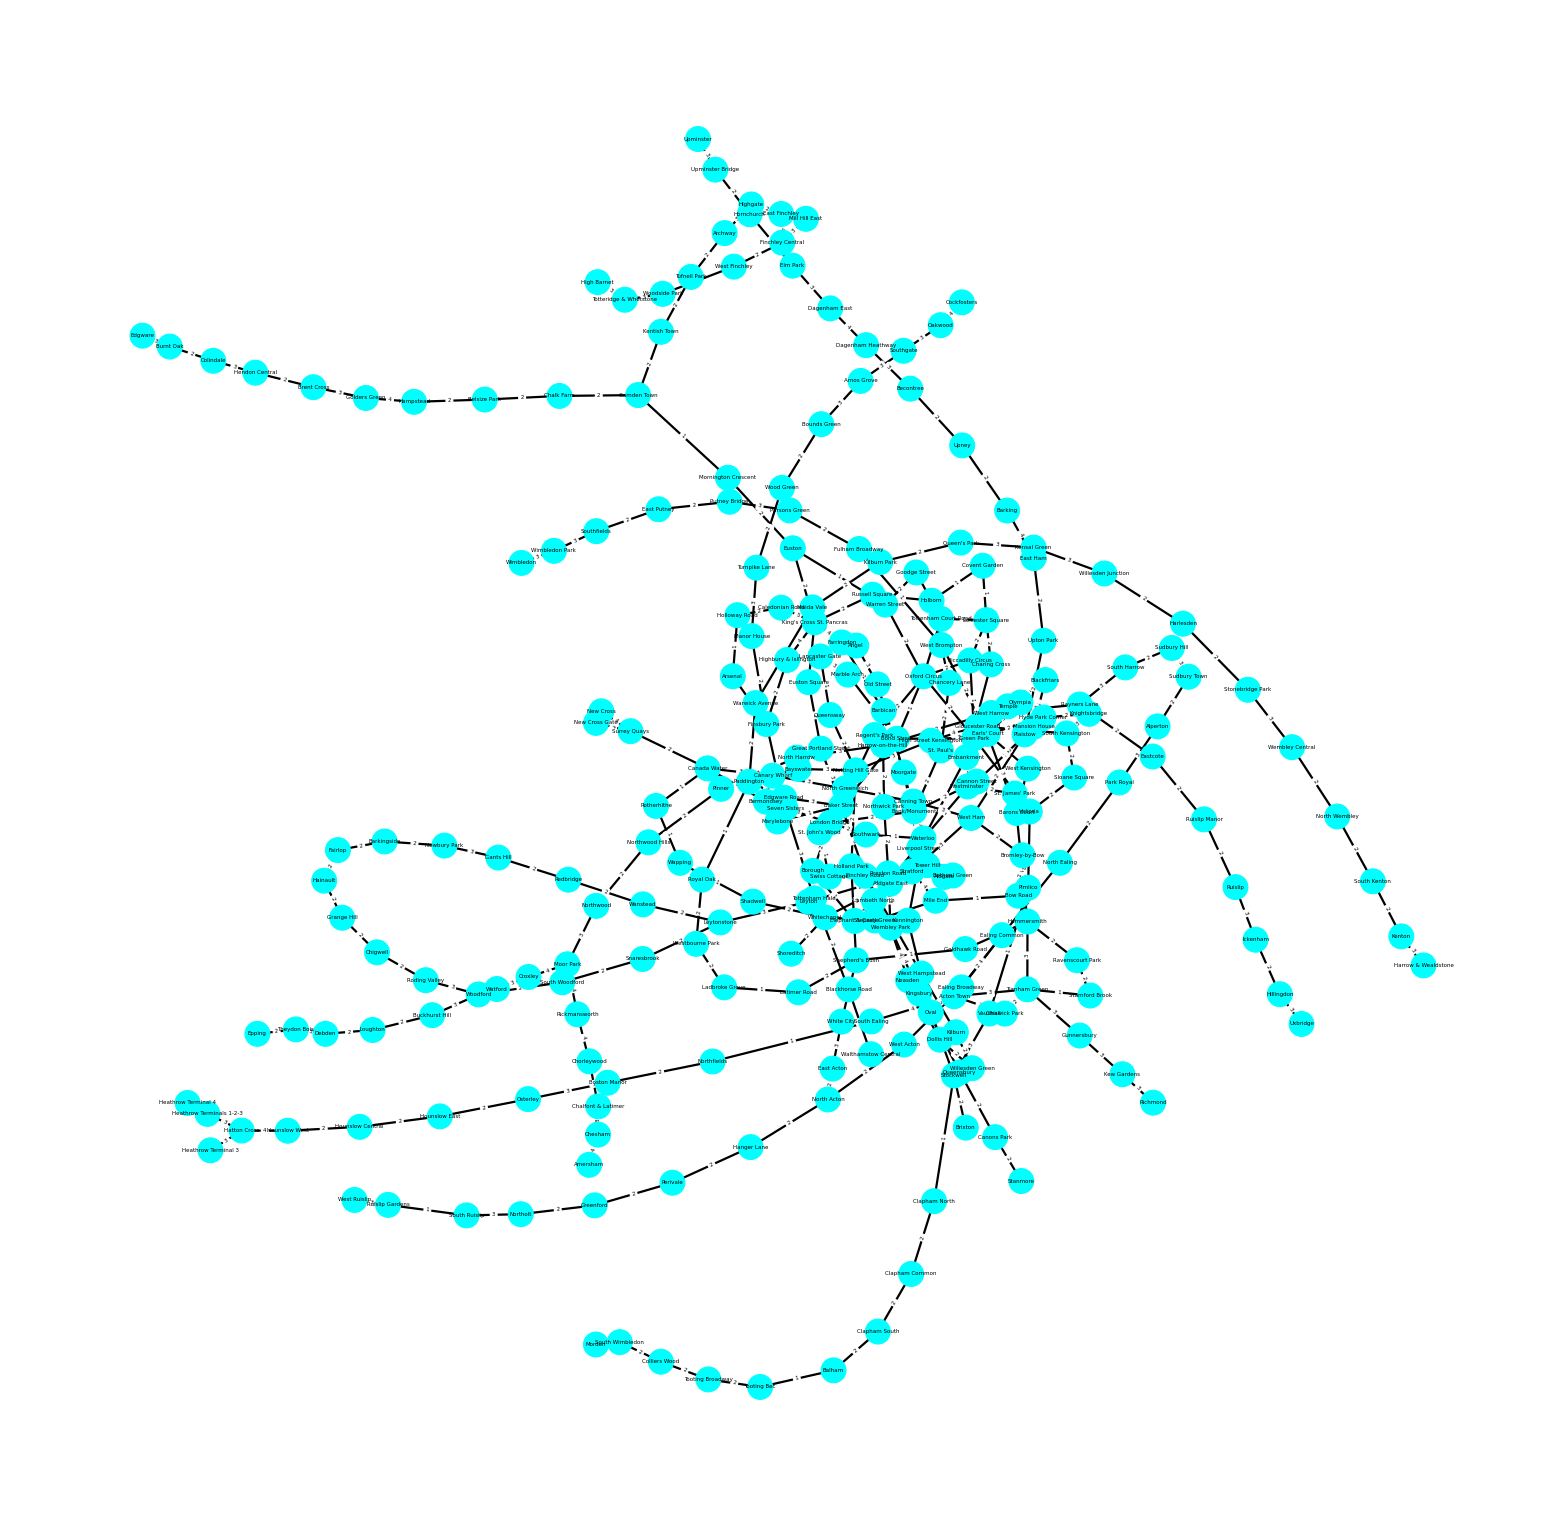

In [ ]:
# Preparing the Data for Search Algorithms
# Creating a nxgraph from data frame

tubes_dict = df1.to_dict('records')     # Converting the data in data frame with headers to a dict based on 'records' i.e. rows

# Taking StartingStation, EndingStation and AverageTimeTaken for the purpose of graph creation
Starting = list(df[0])        
Ending = list(df[1])
Weight = list(df[3])

tubes_graph = nx.Graph()                # defining a graph

# Adding weighted edges to the graph from StartingStation to EndingStation and weight as AverageTimeTaken
for i in range(len(Starting)):
  tubes_graph.add_edge(Starting[i], Ending[i], weight=Weight[i])

# Function which can be called to nicely depict the graph (re-used from Lab 3)
def show_weighted_graph(networkx_graph, node_size, font_size, fig_size):
  plt.figure(num=None, figsize=fig_size, dpi=80)
  plt.axis('off')
  nodes_position = nx.spring_layout(networkx_graph) 
  edges_weights  = nx.get_edge_attributes(networkx_graph,'weight')
  nx.draw_networkx_nodes(networkx_graph, nodes_position, node_size=node_size,  
                         node_color = ["cyan"]*networkx_graph.number_of_nodes())
  nx.draw_networkx_edges(networkx_graph, nodes_position, 
                         edgelist=list(networkx_graph.edges), width=2)
  nx.draw_networkx_edge_labels(networkx_graph, nodes_position, 
                               edge_labels = edges_weights, font_size=font_size)
  nx.draw_networkx_labels(networkx_graph, nodes_position, font_size=font_size, 
                          font_family='sans-serif')
  plt.axis('off')
  plt.show()

show_weighted_graph(tubes_graph, 500, 5, (25,25))

# **2 Agenda-Based Search**
### **2.1 Implement DFS, BFS, and UCS**

In [ ]:
# Function to return path and cost (time in mins) for DFS and BFS
def path_and_cost(node):
    path_from_root = [node['label']]
    cost_of_path = 0
    while node['parent']:
        parent = node['label']
        node = node['parent']
        path_from_root = [node['label']] + path_from_root
        cost_of_path += tubes_graph.get_edge_data(parent, node['label'])['weight']
    return path_from_root, cost_of_path

# Function to return path and cost (time in mins) for UCS
def path_and_cost_function(node):
    cost_of_path = node[0]
    path_from_root = node[2]
    return path_from_root, cost_of_path

The above snippet of code contains the necessary functions which will be used by the search methods to further breakdown the path and its cost which is calculated in minutes.

All three Agenda-Based Search algorithm functions are defined in the following code.

In [ ]:
"""
    DFS Implementation
"""
def depth_first_graph_search(tube, initial, goal, reverse=False):
    """
      frontier is a list of nodes which is a nested dict
    """    
    frontier = [{'label':initial, 'parent':None}]
    explored = {initial}            # set of explored nodes
    number_of_explored_nodes = 1    # to calculate the number of explorations
    cost_of_path = 0

    while frontier:
        node = frontier.pop()           # pop the last element in the frontier
        number_of_explored_nodes += 1   # increase explored count by 1
        if node['label']==goal:         # check if node is goal
            print(f'Number of nodes expanded = {number_of_explored_nodes}')
            return node                 # returns node if it equals goal

        neighbours = reversed(list(tube.neighbors(node['label']))) if reverse else tube.neighbors(node['label'])
        
        for child_label in neighbours:       
            child = {'label':child_label, 'parent':node}
            if child_label not in explored:
                frontier.append(child)      # child is appended to the right of the list as it is a LIFO
                explored.add(child_label)   # add node to explored

    return None


"""
    BFS Implementation
"""
def breadth_first_graph_search(tube, initial, goal, reverse=False):
    
    if initial == goal:             # if initial is goal, return no solution
        return None
    
    number_of_explored_nodes = 1    # to calculate the number of explorations

    """
      frontier is a list of nodes which is a nested dict
    """
    frontier = [{'label':initial, 'parent':None}]
    explored = {initial}            # set of explored nodes
    
    while frontier:
        node = frontier.pop()       # pop the last element in the frontier queue
        
        # get a list of all the child nodes of current node
        neighbours = reversed(list(tube.neighbors(node['label']))) if reverse else tube.neighbors(node['label'])


        for child_label in neighbours:
            child = {'label':child_label, 'parent':node}
            if child_label==goal:     # check if child is goal
                print(f'Number of nodes expanded = {number_of_explored_nodes}')
                return child          # returns child if it equals goal

            # check if the child node is not explored
            if child_label not in explored:
                frontier = [child] + frontier   # child is added to the left of the list as it is a FIFO
                number_of_explored_nodes += 1   # increase explored count by 1
                explored.add(child_label)       # add node to explored
            
    return None

"""
    UCS Implementation
"""
def uniform_cost_graph_search(tube, initial, goal, reverse=False):
    frontier = []     # frontier used is list of nodes
    frontierDict = {}
    """
      node is a tuple
      contains structure as (Total_Time_Taken, 'EndStation', ['List_of_Station_explored_from_Initial_to_reach_EndStation'])
    """
    node = (0, initial, [initial])

    """ 
      Use frontierDict a dictionary to keep track of the elements inside the frontier (queue)
      Contains structure as {'EndStation': [Total_Time_Taken, ['List_of_Station_explored_from_Initial_to_reach_EndStation']]}
    """
    frontierDict[node[1]] = [node[0], node[2]]
    
    
    heapq.heappush(frontier, node)    # insert the node inside the frontier (queue)
    explored = set()                  # set of explored nodes     
    
    while frontier:
      if len(frontier) == 0:          # if frontier is empty, return no solution
        return None

      node = heapq.heappop(frontier)  # pop elemenet with lower path cost in the queue
      del frontierDict[node[1]]       # delete the element that has been popped from frontierIndex
      
      if node[1] == goal:             # check if the solution has been found
        print(f'Number of nodes expanded = {len(explored)}')
        return node
      explored.add(node[1])           # add node to explored
      
      # get a list of all the child nodes of current node
      neighbours = reversed(list(tube.neighbors(node[1]))) if reverse else tube.neighbors(node[1])
      path = node[2]      # path contains a list of all the nodes explored to reach current node

      for child in neighbours:
        path.append(child)
        
        childNode = (node[0] + tube.get_edge_data(node[1], child)["weight"], child, path) # childNode that will be inserted in frontier
        
        # check if the child node is not explored and not in frontier through the dictionary
        if child not in explored and child not in frontierDict:
          heapq.heappush(frontier, childNode)
          frontierDict[child] = [childNode[0], childNode[2]]    # update the frontierDict
        elif child in frontierDict:
          # Checks if the child node has a lower path cost than the node already in frontier, if present replace it with lower cost node
          if childNode[0] < frontierDict[child][0]:
            highCost_node = (frontierDict[child][0], child, frontierDict[child][1])
            frontier.remove(highCost_node)          # if node with higher cost path exist, remove it from frontier
            heapq.heapify(frontier)                 # transforms frontier into heapq
            del frontierDict[child]                 # delete the node from frontierDict
            heapq.heappush(frontier, childNode)     # insert the childNode in frontier 
            frontierDict[child] = [childNode[0], childNode[2]]    # update the frontierDict

        path = path[:-1]    # update the path if child is explored

Before implementing Agend-Based searches followed by Extend and Heuristic searches, select any Starting and Ending station and update the variables 'Start' and 'End'. 

In [ ]:
Start = 'Euston'
End = 'Victoria'


print(f'DFS Results for path {Start} to {End}:')
DFS_solution = depth_first_graph_search(tubes_graph, Start, End)
DFS_path, DFS_cost = path_and_cost(DFS_solution)
print(f'Total cost of the path (in mins) = {DFS_cost}')
print(f'Number of stations visited = {len(DFS_path)}')
print(f'Path:\n {DFS_path}\n')

print(f'BFS Results for path {Start} to {End}:')
BFS_solution = breadth_first_graph_search(tubes_graph, Start, End)
BFS_path, BFS_cost = path_and_cost(BFS_solution)
print(f'Total cost of the path (in mins) = {BFS_cost}')
print(f'Number of stations visited = {len(BFS_path)}')
print(f'Path:\n {BFS_path}\n')

print(f'UCS Results for path {Start} to {End}:')
UCS_solution = uniform_cost_graph_search(tubes_graph, Start, End)
UCS_path, UCS_cost = path_and_cost_function(UCS_solution)
print(f'Total cost of the path (in mins) = {UCS_cost}')
print(f'Number of stations visited = {len(UCS_path)}')
print(f'Path:\n {UCS_path}')

DFS Results for path Euston to Victoria:
Number of nodes expanded = 26
Total cost of the path (in mins) = 13
Number of stations visited = 9
Path:
 ['Euston', "King's Cross St. Pancras", 'Russell Square', 'Holborn', 'Covent Garden', 'Leicester Square', 'Piccadilly Circus', 'Green Park', 'Victoria']

BFS Results for path Euston to Victoria:
Number of nodes expanded = 34
Total cost of the path (in mins) = 7
Number of stations visited = 5
Path:
 ['Euston', 'Warren Street', 'Oxford Circus', 'Green Park', 'Victoria']

UCS Results for path Euston to Victoria:
Number of nodes expanded = 34
Total cost of the path (in mins) = 7
Number of stations visited = 5
Path:
 ['Euston', 'Warren Street', 'Oxford Circus', 'Green Park', 'Victoria']


### **2.3 Extending the cost function**
Improving the current UCS cost function by including the time to change lines at one station (here, 2 minutes).

In [ ]:
# This function returns the tubeline that exist between the node and the child

def find_line(node, child):
  current_line = None
  for i in tubes_dict:
    if i['StartingStation']==node and i['EndingStation']==child:
      return i['TubeLine']
        
  if current_line == None:
    for i in tubes_dict:
      if i['EndingStation']==node and i['StartingStation']==child:
        return i['TubeLine']

In [ ]:
"""
    Extended UCS Implementation
"""
def extended_uniform_cost_graph_search(tube_graph, initial, goal, reverse=False):
    frontier = []                     # frontier used is list of nodes
    frontierDict = {}
    """
      node is a tuple
      contains structure as (Total_Time_Taken, 'EndStation', ['List_of_Station_explored_from_Initial_to_reach_EndStation'])
    """
    node = (0, initial, [initial])
    
    """ 
      Use frontierDict a dictionary to keep track of the elements inside the frontier (queue)
      Contains structure as {'EndStation': [Total_Time_Taken, ['List_of_Station_explored_from_Initial_to_reach_EndStation']]}
    """
    frontierDict[node[1]] = [node[0], node[2]]
    
    heapq.heappush(frontier, node)    # insert the node inside the frontier (queue)
    explored = set()                  # set of explored nodes

    TransitTime = 2                   # Station Transit Time if the TubeLine has to be changed
    
    line_list = ['LineStart']         # list to maintain the TubeLines passed
    
    while frontier:
      if len(frontier) == 0:          # if frontier is empty, return no solution
        return None

      node = heapq.heappop(frontier)  # pop elemenet with lower path cost in the queue
      del frontierDict[node[1]]       # delete the element that has been popped from frontierIndex
      
      if node[1] == goal:             # check if the solution has been found
        print(f'Number of explorations = {len(explored)}')
        return node
      explored.add(node[1])           # add node to explored
      
      # get a list of all the child nodes of current node
      neighbours = reversed(list(tube_graph.neighbors(node[1]))) if reverse else tube_graph.neighbors(node[1])
      path = node[2]                  # path contains a list of all the nodes explored to reach current node

      for child in neighbours:
        path.append(child)

        current_line = find_line(node[1], child)

        """
          Here is the implementation of the Extended Function
          Check if the current_line exists in the list, if it exist don't add
          If it does't, check if its similar to the previous line. If it not, add 2 to the AverageTimeTaken as TransitTime
        """
        if  current_line not in line_list:
          if current_line == line_list[-1]:
            cost_child = node[0] + tube_graph.get_edge_data(node[1], child)["weight"]
          else:
            if line_list[-1] == 'LineStart':
              cost_child = node[0] + tube_graph.get_edge_data(node[1], child)["weight"]
            cost_child = node[0] + tube_graph.get_edge_data(node[1], child)["weight"] + TransitTime
            line_list.append(current_line)
        else:
           cost_child = node[0] + tube_graph.get_edge_data(node[1], child)["weight"]
  

        childNode = (cost_child, child, path)     # childNode that will be inserted in frontier based on following condition
        
        # check if the child node is not explored and not in frontier through the dictionary
        if child not in explored and child not in frontierDict:
          heapq.heappush(frontier, childNode)
          frontierDict[child] = [childNode[0], childNode[2]]    # update the frontierDict
        elif child in frontierDict:
          # checks if the child node has a lower path cost than the node already in frontier, if present replace it with lower cost node
          if childNode[0] < frontierDict[child][0]:
            highCost_node = (frontierDict[child][0], child, frontierDict[child][1])
            frontier.remove(highCost_node)          # if node with higher cost path exist, remove it from frontier
            heapq.heapify(frontier)                 # transforms frontier into heapq
            del frontierDict[child]                 # delete the node from frontierDict
            heapq.heappush(frontier, childNode)     # insert the childNode in frontier 
            frontierDict[child] = [childNode[0], childNode[2]]    # update the frontierDict

        path = path[:-1]                            # update the path if child is explored

print(f'Extended UCS Results for path {Start} to {End}:')
UCS_Extended_solution = extended_uniform_cost_graph_search(tubes_graph, Start, End)
UCS_Extended_path, UCS_Extended_cost = path_and_cost_function(UCS_Extended_solution)
print(f'Total cost of the path (in mins) = {UCS_Extended_cost}')
print(f'Number of stations visited = {len(UCS_Extended_path)}')
print(f'Path:\n {UCS_Extended_path}')

Extended UCS Results for path Euston to Victoria:
Number of explorations = 36
Total cost of the path (in mins) = 9
Number of stations visited = 5
Path:
 ['Euston', 'Warren Street', 'Oxford Circus', 'Green Park', 'Victoria']


### **2.4 Heuristic search**

The heuristic function is to be selected based on the Zone values. The admissible heuristic chosen is absolute difference between the goal zone and node zone.



In [ ]:
# This function returns the zone of the station

def find_zone(station):
  zone = None
  
  for i in tubes_dict:
    if i['EndingStation']==station:
      zone = i['MainZone']
  
  if zone == None:
    for i in tubes_dict:
      if i['StartingStation']==station:
        zone = i['SecondaryZone']
  
  return zone

Here we define the decided heuristic function.

In [ ]:
# Heuristic function which returns the absolute difference between the goal zone and node zone

def heuristic_function(goal, node):
  goal_zone = float(find_zone(goal))
  node_zone = float(find_zone(node))
  return abs(goal_zone-node_zone)

In [ ]:
# function to return path and cost (time in mins) for BFS
def path_and_cost_function_heuristic(node):
    cost_of_path = node[3]
    path_from_root = node[2]
    return path_from_root, cost_of_path

"""
    Heuristic Best First Search
"""
def heuristic_best_first_graph_search(tube, initial, goal, reverse=False):
    frontier = []     # frontier used is list of nodes
    frontierDict = {}

    """
      node is a tuple
      contains structure as (Heuristic_Total, 'EndStation', ['List_of_Station_explored_from_Initial_to_reach_EndStation'], Total_Time_Taken)
    """
    node = (0, initial, [initial], 0)

    """ 
      Use frontierDict a dictionary to keep track of the elements inside the frontier (queue)
      Contains structure as {'EndStation': [Heuristic_Total, ['List_of_Station_explored_from_Initial_to_reach_EndStation'], Total_Time_Taken]}
    """
    frontierDict[node[1]] = [node[0], node[2], node[3]]
    
    
    heapq.heappush(frontier, node)    # insert the node inside the frontier (queue)
    explored = set()                  # set of explored nodes     
    
    while frontier:
      if len(frontier) == 0:          # if frontier is empty, return no solution
        return None

      node = heapq.heappop(frontier)  # pop elemenet with lower path cost in the queue
      del frontierDict[node[1]]       # delete the element that has been popped from frontierIndex
      
      if node[1] == goal:             # check if the solution has been found
        print(f'Number of nodes expanded = {len(explored)}')
        return node
      explored.add(node[1])           # add node to explored
      
      # get a list of all the child nodes of current node
      neighbours = reversed(list(tube.neighbors(node[1]))) if reverse else tube.neighbors(node[1])
      path = node[2]      # path contains a list of all the nodes explored to reach current node

      for child in neighbours:
        path.append(child)
        
        h = heuristic_function(goal, child)

        childNode = (node[0]+h, child, path, node[3] + tube.get_edge_data(node[1], child)["weight"]) # childNode that will be inserted in frontier
        
        # check if the child node is not explored and not in frontier through the dictionary
        if child not in explored and child not in frontierDict:
          heapq.heappush(frontier, childNode)
          frontierDict[child] = [childNode[0], childNode[2], childNode[3]]    # update the frontierDict
        elif child in frontierDict:
          # Checks if the child node has a lower path cost than the node already in frontier, if present replace it with lower cost node
          if childNode[0] < frontierDict[child][0]:
            highCost_node = (frontierDict[child][0], child, frontierDict[child][1], frontierDict[child][3])
            frontier.remove(highCost_node)          # if node with higher cost path exist, remove it from frontier
            heapq.heapify(frontier)                 # transforms frontier into heapq
            del frontierDict[child]                 # delete the node from frontierDict
            heapq.heappush(frontier, childNode)     # insert the childNode in frontier 
            frontierDict[child] = [childNode[0], childNode[2], childNode[3]]    # update the frontierDict

        path = path[:-1]    # update the path if child is explored

print(f'Heuristic BFS Results for path {Start} to {End}:')
HBFS_solution = heuristic_best_first_graph_search(tubes_graph, Start, End)
HBFS_path, HBFS_cost = path_and_cost_function_heuristic(HBFS_solution)
print(f'Total cost of the path (in mins) = {HBFS_cost}')
print(f'Number of stations visited = {len(HBFS_path)}')
print(f'Path:\n {HBFS_path}')

Heuristic BFS Results for path Euston to Victoria:
Number of nodes expanded = 58
Total cost of the path (in mins) = 7
Number of stations visited = 5
Path:
 ['Euston', 'Warren Street', 'Oxford Circus', 'Green Park', 'Victoria']
